# 24FS\_I4DS27: Adversarial Attacks - Wie kann KI überlistet werden? <br> 10-UAP-Notebook

In diesem Notebook betrachten wir die unterschiedlichen UAPs an, die durch die Pipeline generiert wird.

In [1]:
%load_ext autoreload
%autoreload 2

import os
if os.getcwd() == '/home/jovyan/work': # jhub
    os.chdir("24FS_I4DS27/main/") 
    os.system("make reqs")
else: # local
    os.chdir("../")

from src.utils.uap_eda import UAP_EDA

### Initialisierung

In [2]:
uaps_resnet_covidx = UAP_EDA(model="resnet50",
                             dataset="covidx_data",
                             n_image=100,
                             max_robustification_level=5)

### UAP Visualisierung

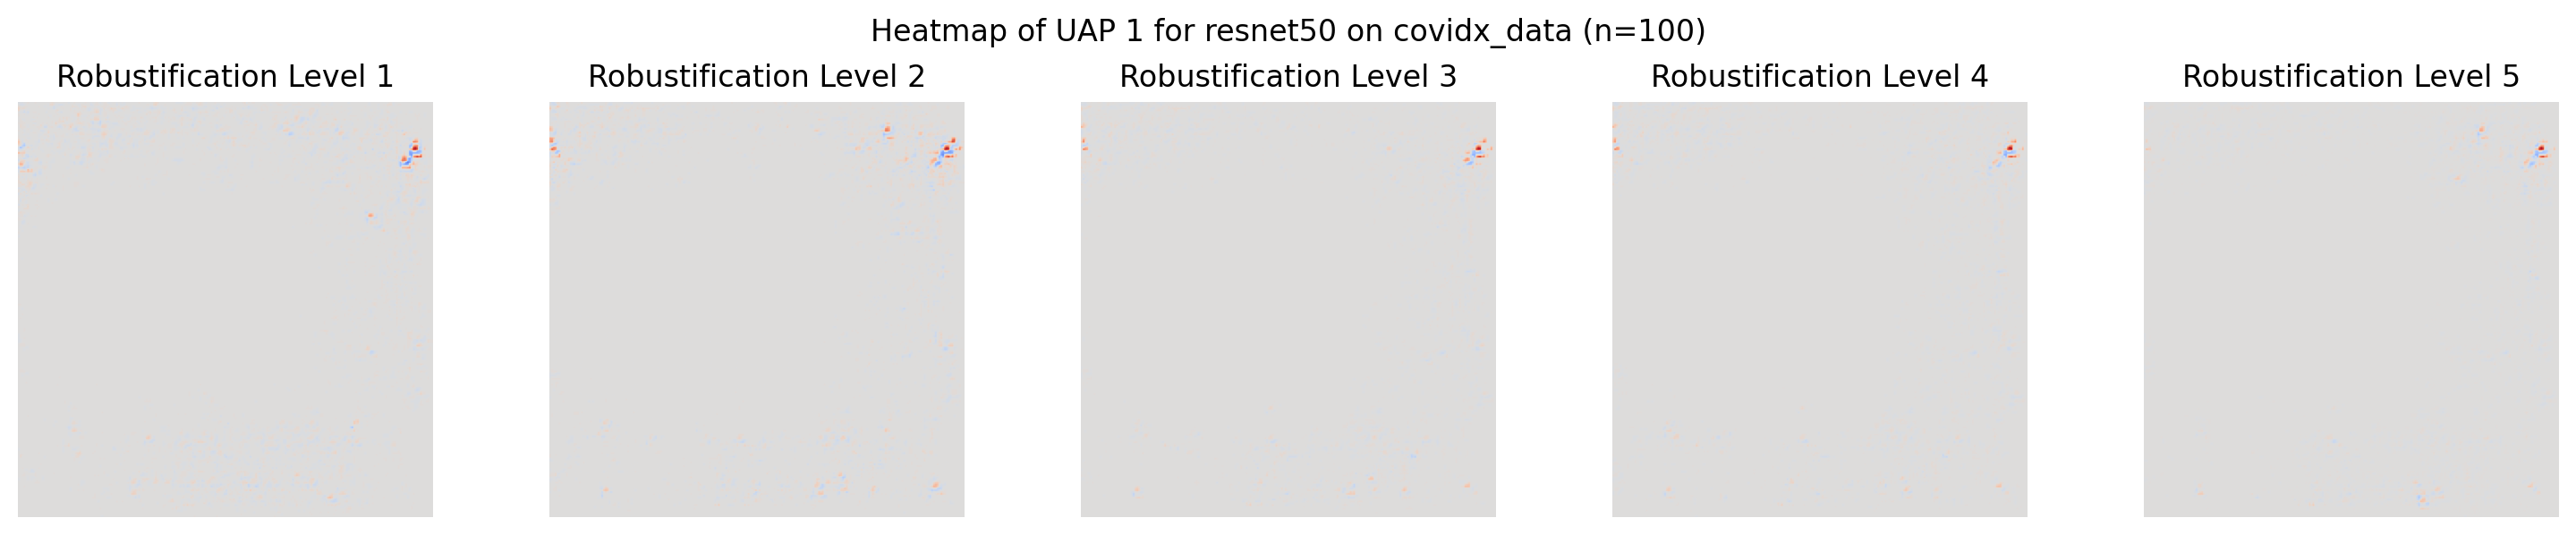

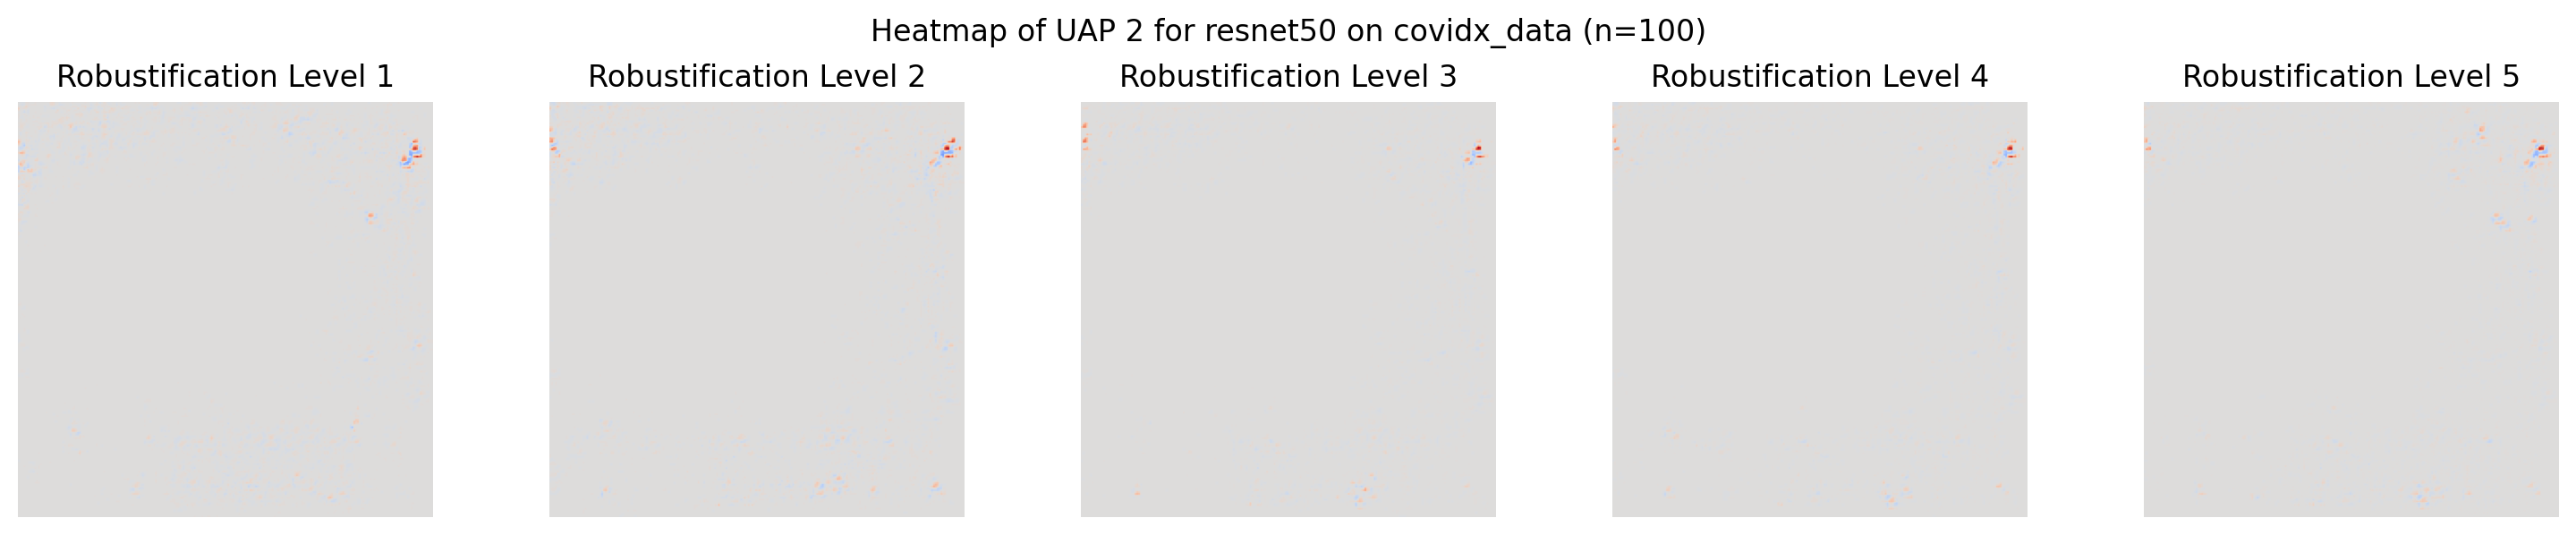

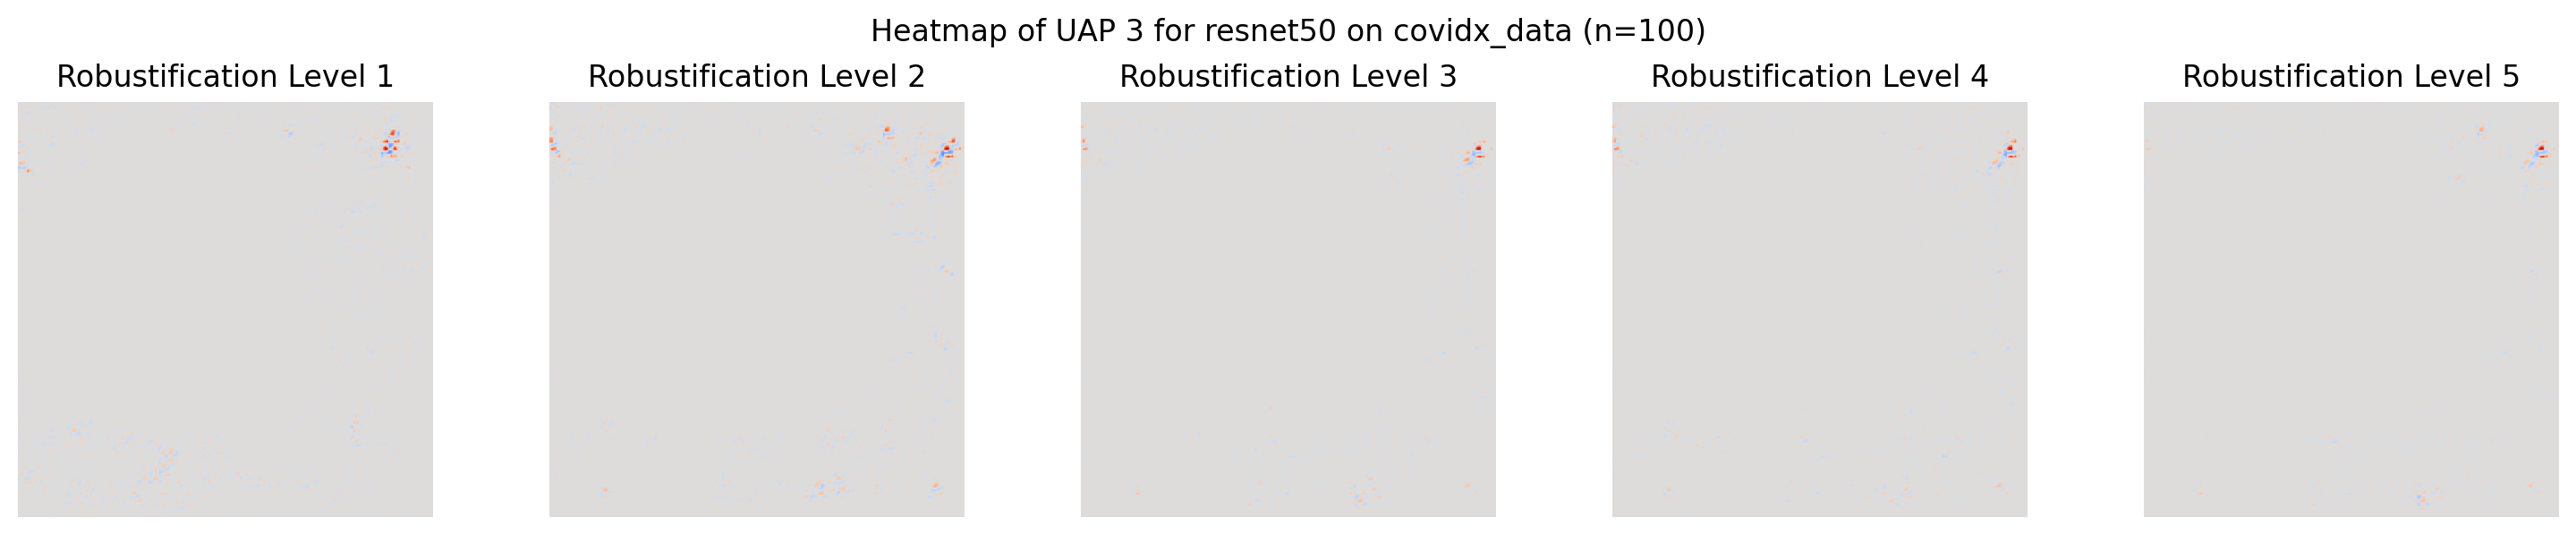

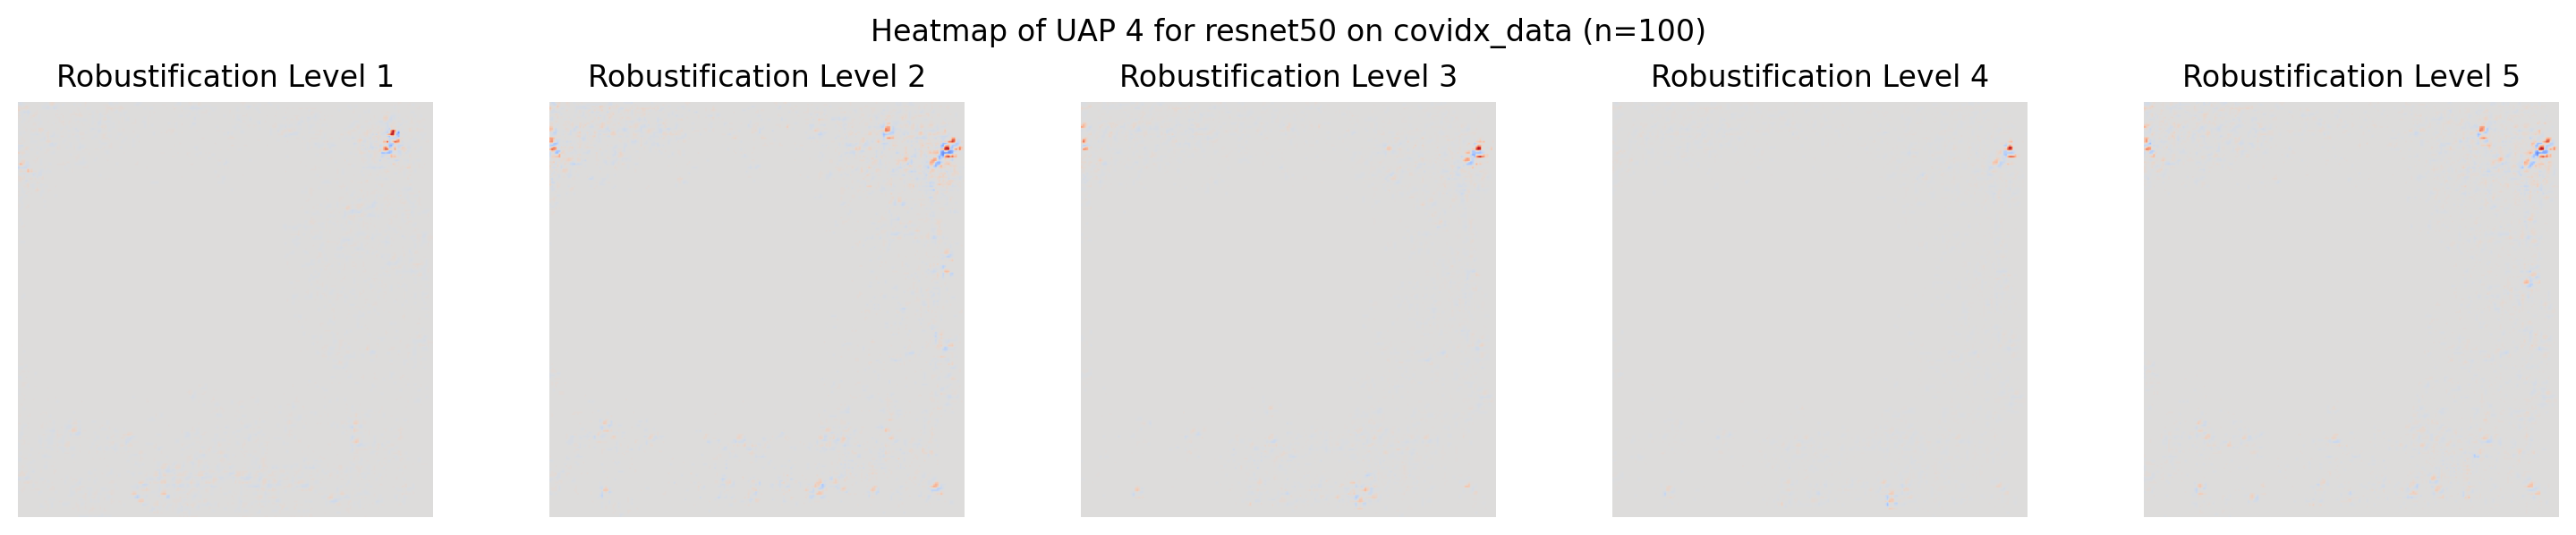

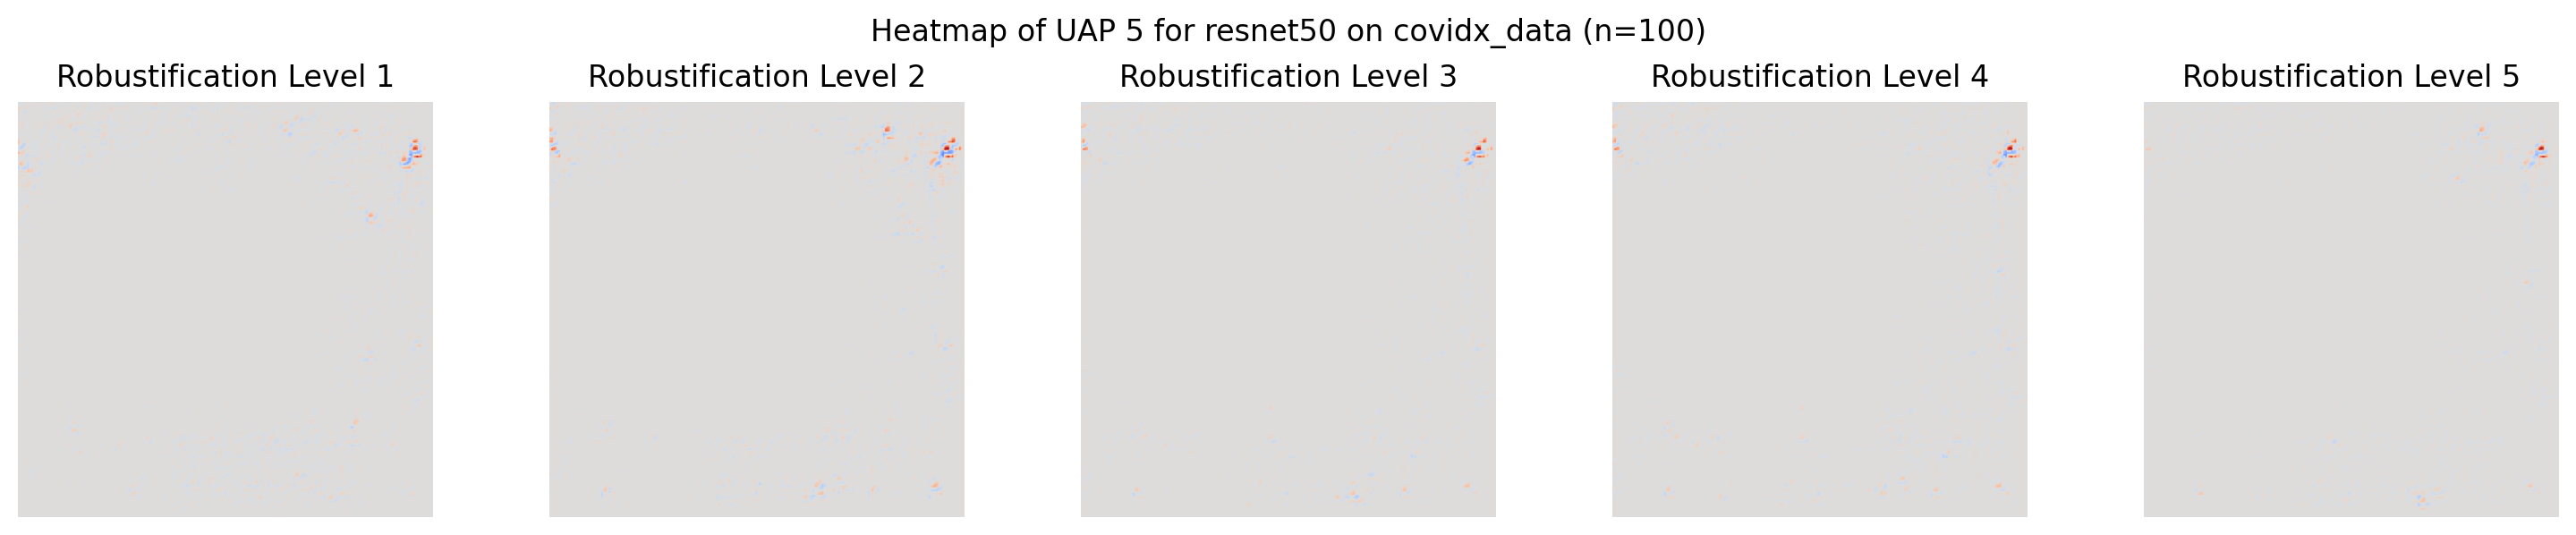

In [34]:
uaps_resnet_covidx.visualize_uaps_tensor(progress=False)

### UAP Violinplot

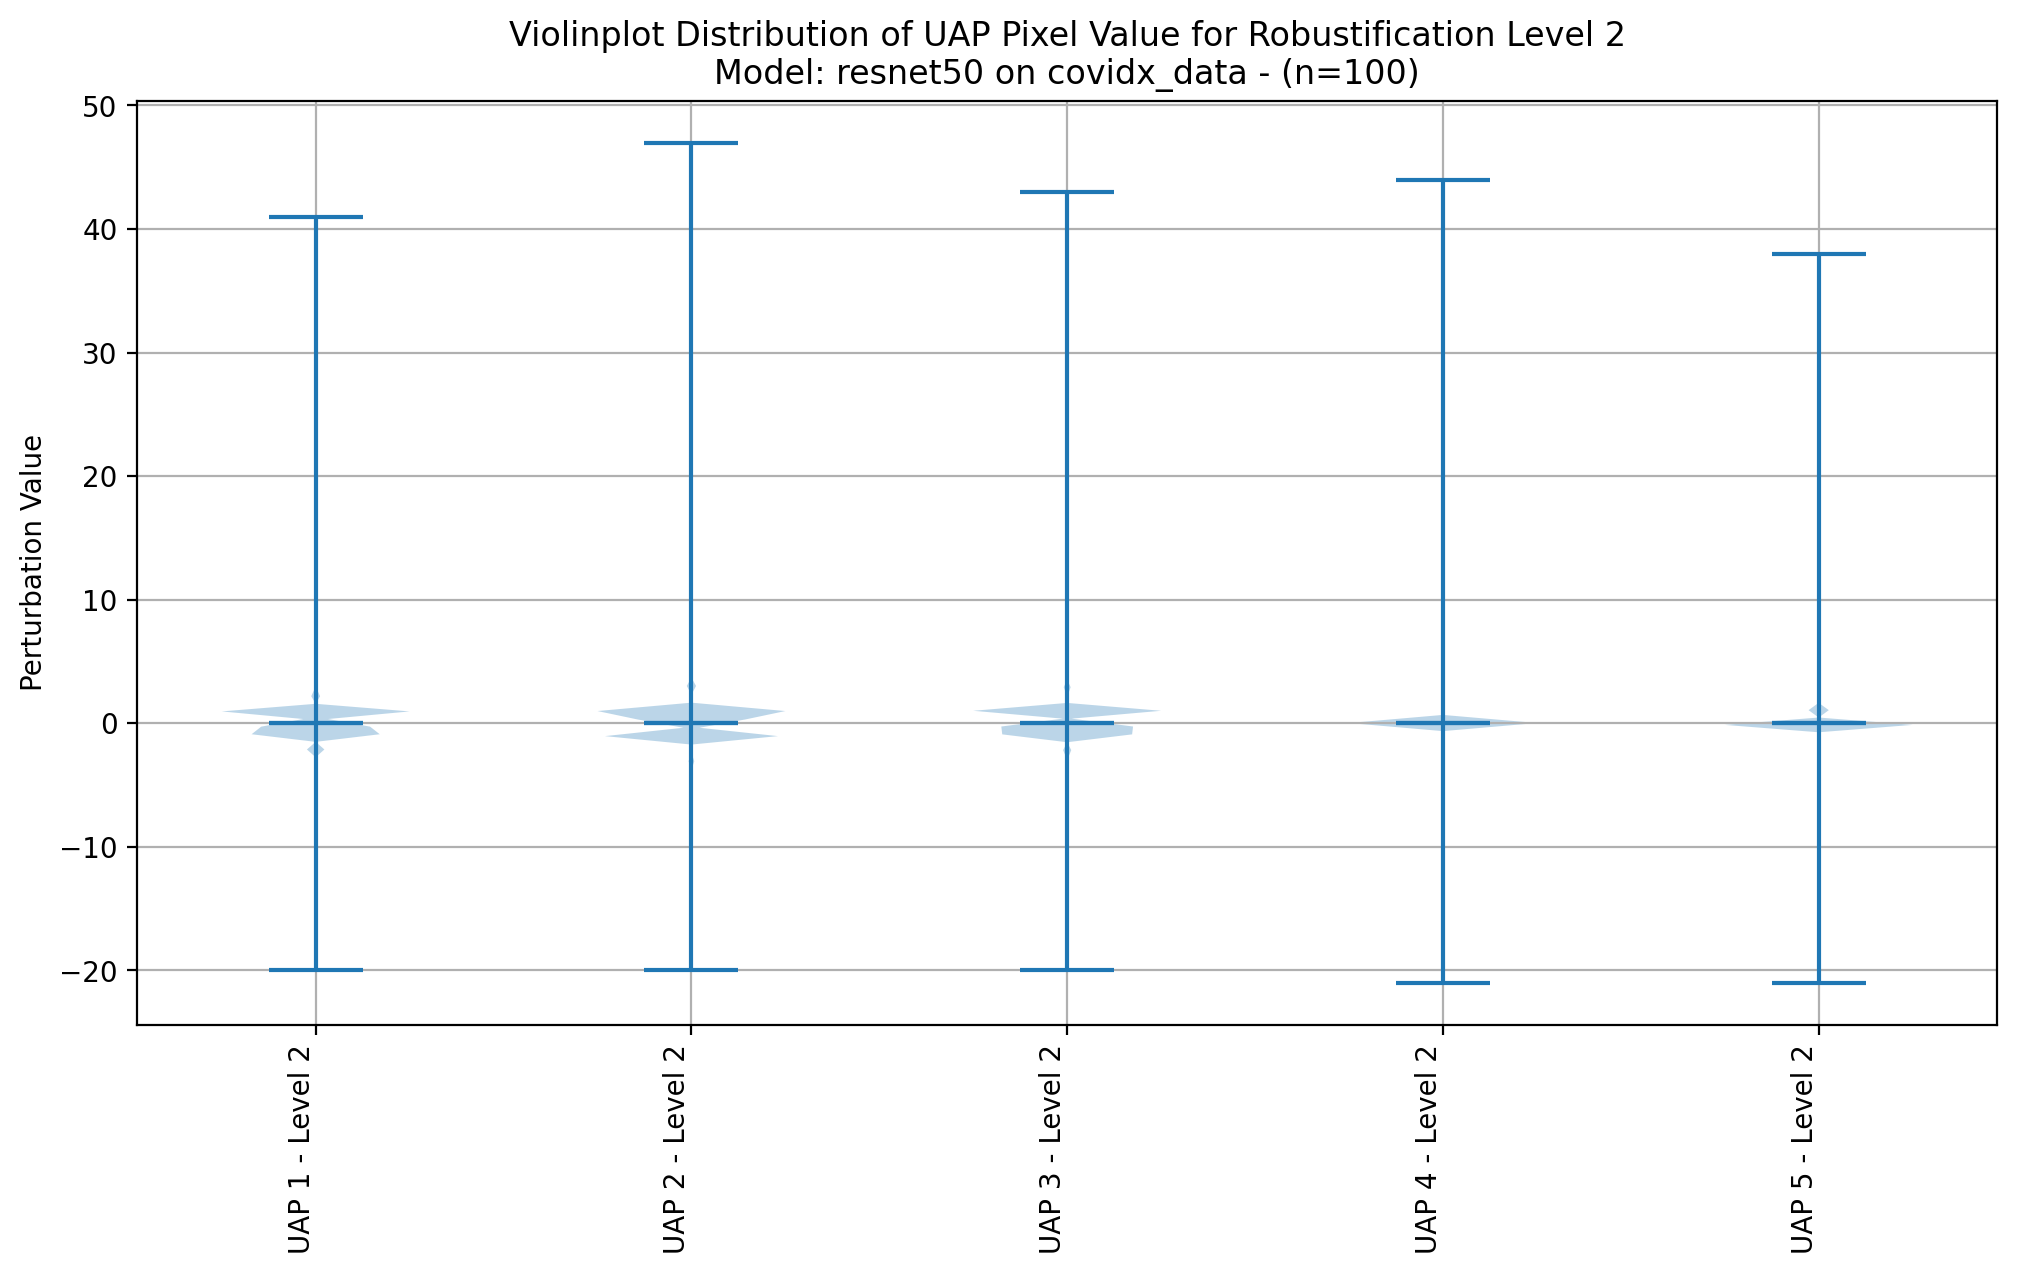

In [22]:
uaps_resnet_covidx.visualize_uap_violinplot(robustification_level=2)

### Defined UAP Visualisierung

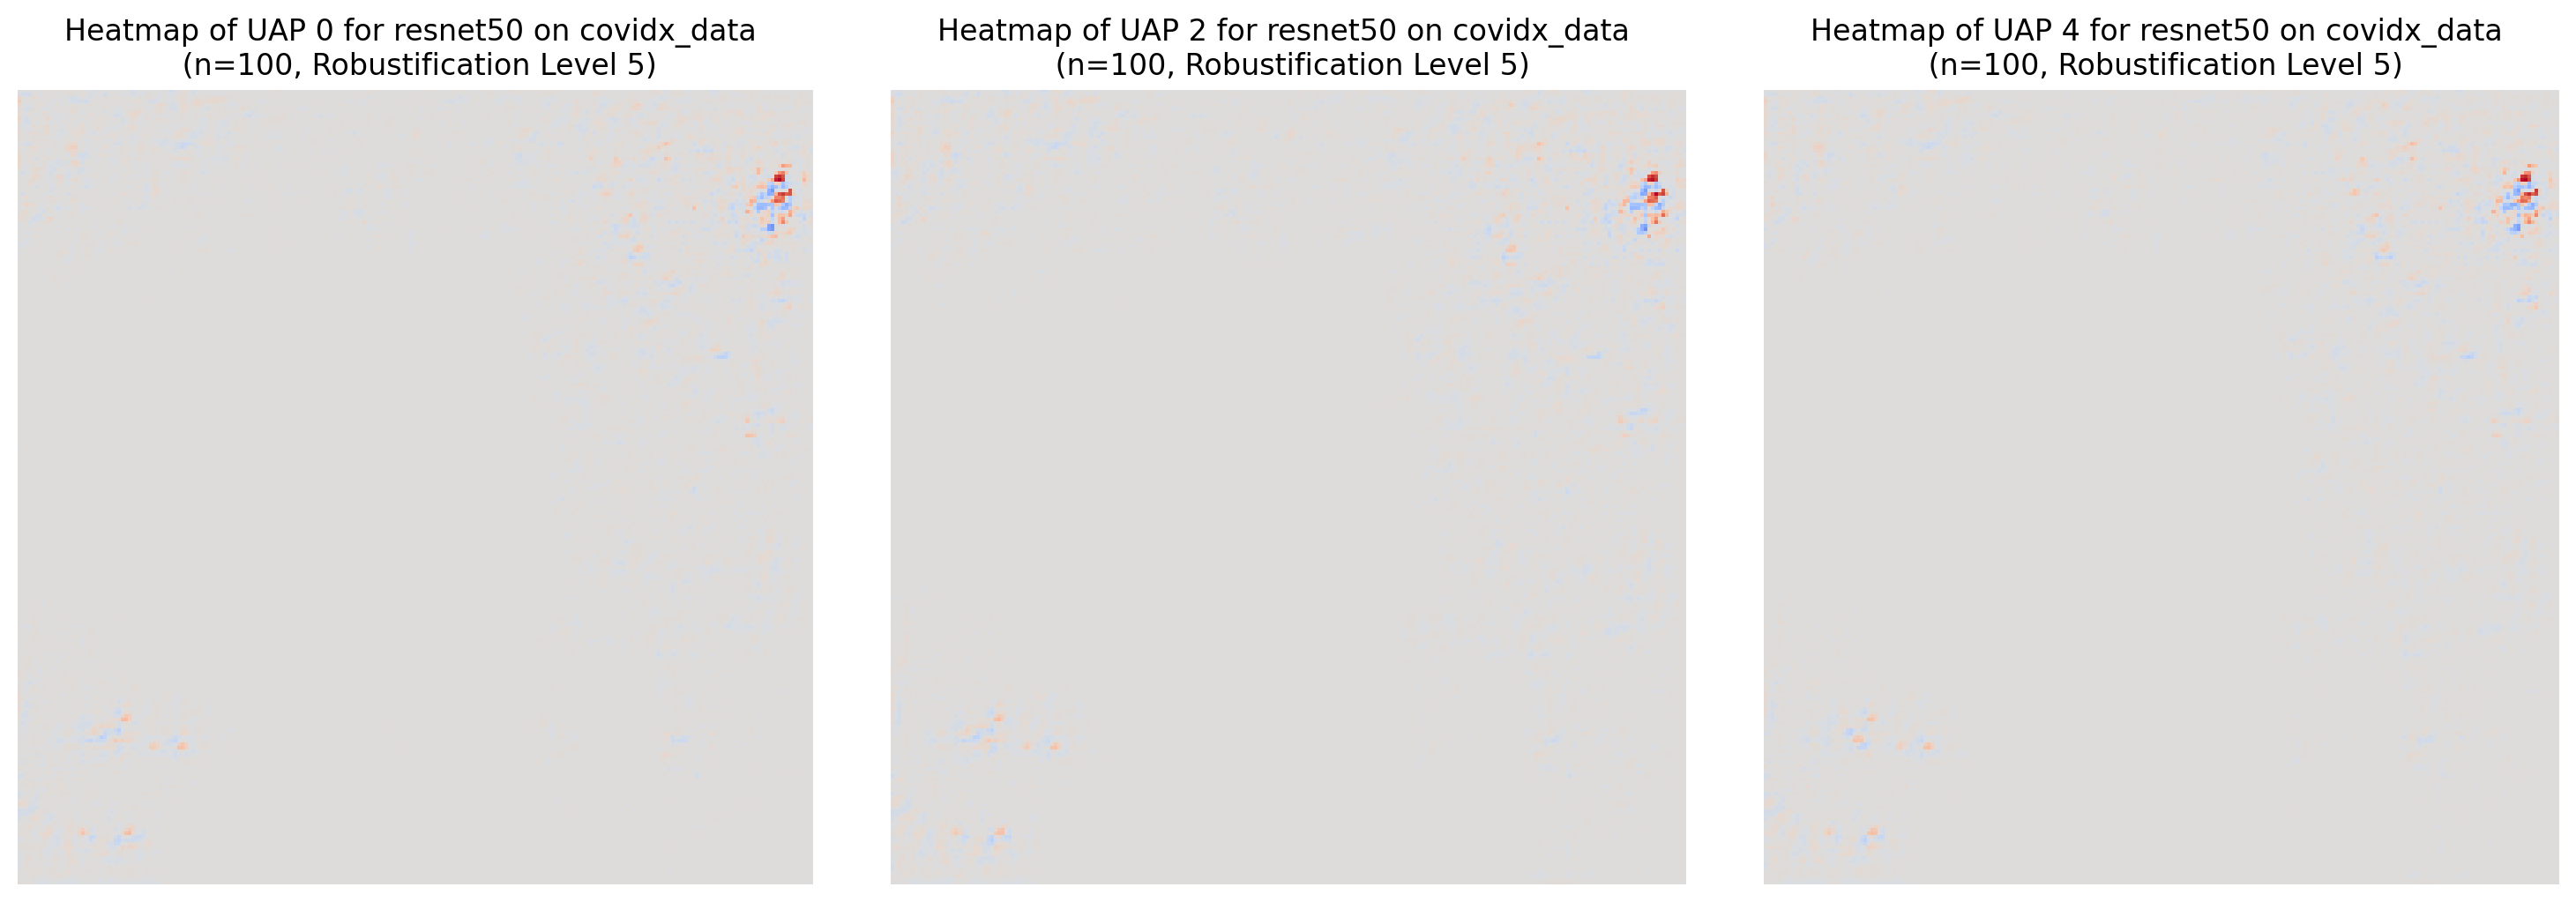

In [15]:
uaps_resnet_covidx.visualize_multiple_uaps(uap_indices=[0,2,4], robustification_level=5)

In [104]:
p.return_uap_tensor(max_robustification=4).shape

File not found at robustified_models/resnet50-covidx_data-n_100-robustification_3/01_UAPs_pre_robustification/UAPs_tensor.pt
Skipping tensor for robustification level 3 due to missing file.


torch.Size([3, 5, 3, 224, 224])

In [59]:
perturb = p.return_uap_tensor(max_robustification=4)[0][0]

File not found at robustified_models/resnet50-covidx_data-n_100-robustification_3/01_UAPs_pre_robustification/UAPs_tensor.pt
Skipping tensor for robustification level 3 due to missing file.


In [60]:
perturb

tensor([[[-1.0377, -1.2697, -1.5925,  ...,  0.0626,  0.1933,  0.1583],
         [-0.9893, -2.1133, -2.7257,  ...,  0.2484,  0.2114,  0.1923],
         [ 1.9154,  1.5884,  0.7745,  ..., -0.1243,  0.0352,  0.1170],
         ...,
         [ 0.3812,  0.1565,  0.2320,  ..., -0.0830, -0.0986,  0.0141],
         [ 0.3234, -0.2032, -0.3184,  ..., -0.1318, -0.0929, -0.0160],
         [ 0.1249, -0.4312, -0.3846,  ..., -0.1376,  0.0586,  0.0415]],

        [[-1.1575, -1.2976, -1.4515,  ...,  0.0464,  0.1913,  0.1462],
         [-0.9873, -2.1784, -2.7693,  ...,  0.1612,  0.2147,  0.1890],
         [ 1.8787,  1.2614,  0.6964,  ..., -0.1412,  0.0728,  0.0914],
         ...,
         [ 0.3335,  0.1900,  0.1517,  ..., -0.0983, -0.0971,  0.0135],
         [ 0.3407, -0.1365, -0.1591,  ..., -0.1335, -0.0951, -0.0167],
         [ 0.2160, -0.3566, -0.3217,  ..., -0.1422,  0.0198,  0.0042]],

        [[-1.0767, -1.3409, -1.5919,  ...,  0.0312,  0.1222,  0.1561],
         [-0.9726, -2.1992, -2.8394,  ...,  0

In [61]:
perturb.shape

torch.Size([3, 224, 224])

In [12]:
from src.data.mri import MRIDataModules
from src.data.covidx import COVIDXDataModule
from src.utils.eda import ExplorativeDataAnalysis
import torchvision

In [13]:
BATCH_SIZE = 1
IMAGE_SIZE = (224, 224)

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224), antialias=True),
    ]
)

In [17]:
MRIdata = MRIDataModule(
    path="data/raw/Brain-Tumor-MRI",
    path_processed="data/processed/Brain-Tumor-MRI",
    transform=transform,
    batch_size=BATCH_SIZE,
    train_shuffle=True,
).setup()

COVIDXdata = COVIDXDataModule(
    path="data/raw/COVIDX-CXR4",
    transform=transform,
    batch_size=BATCH_SIZE,
    train_shuffle=True,
).setup()


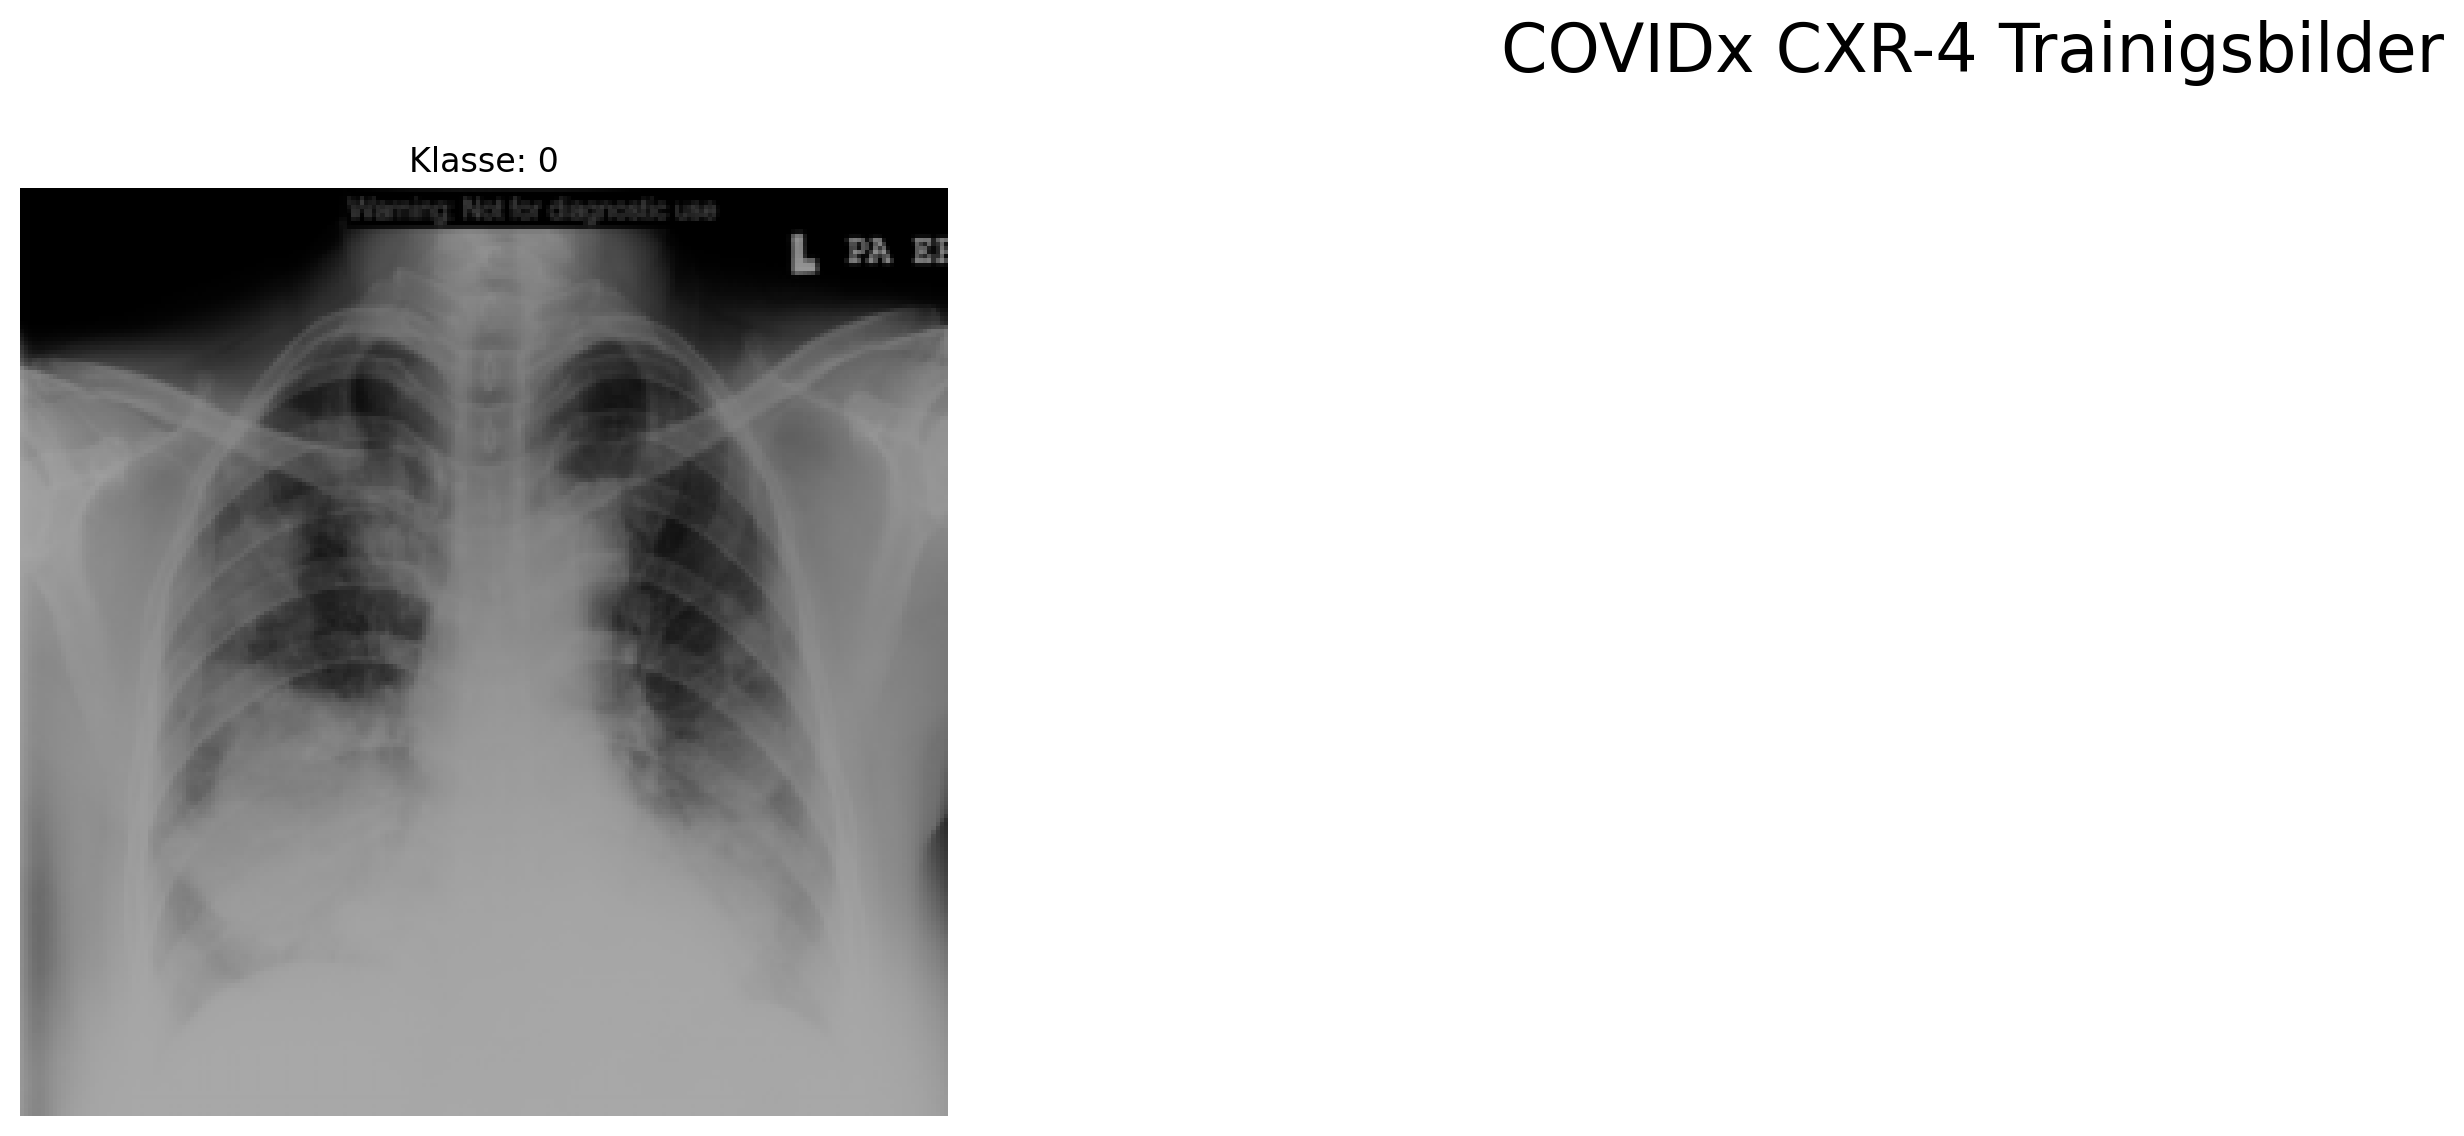

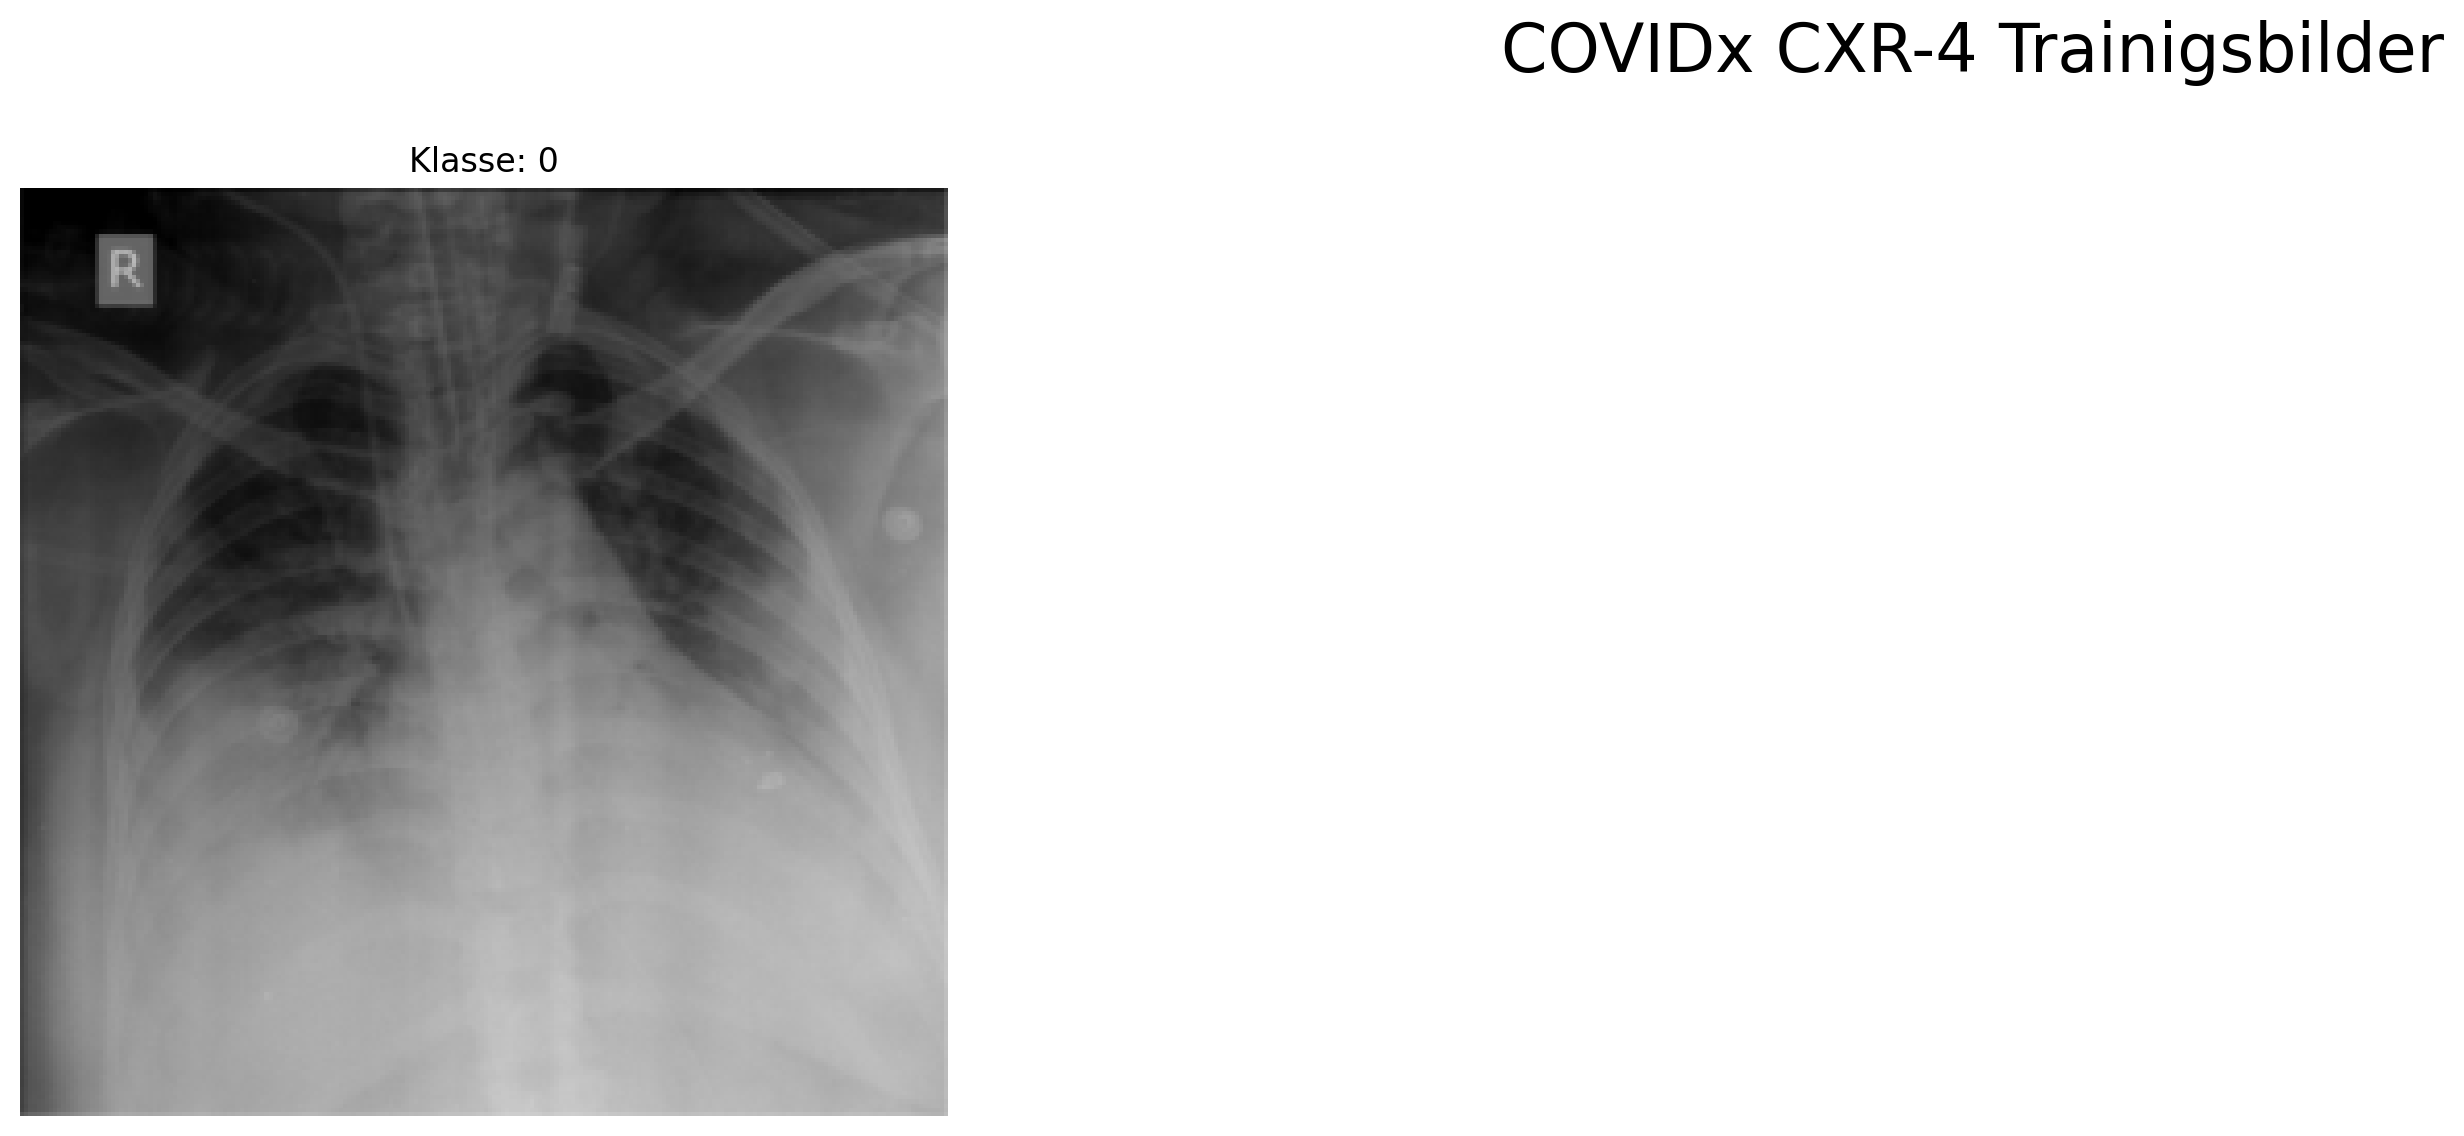

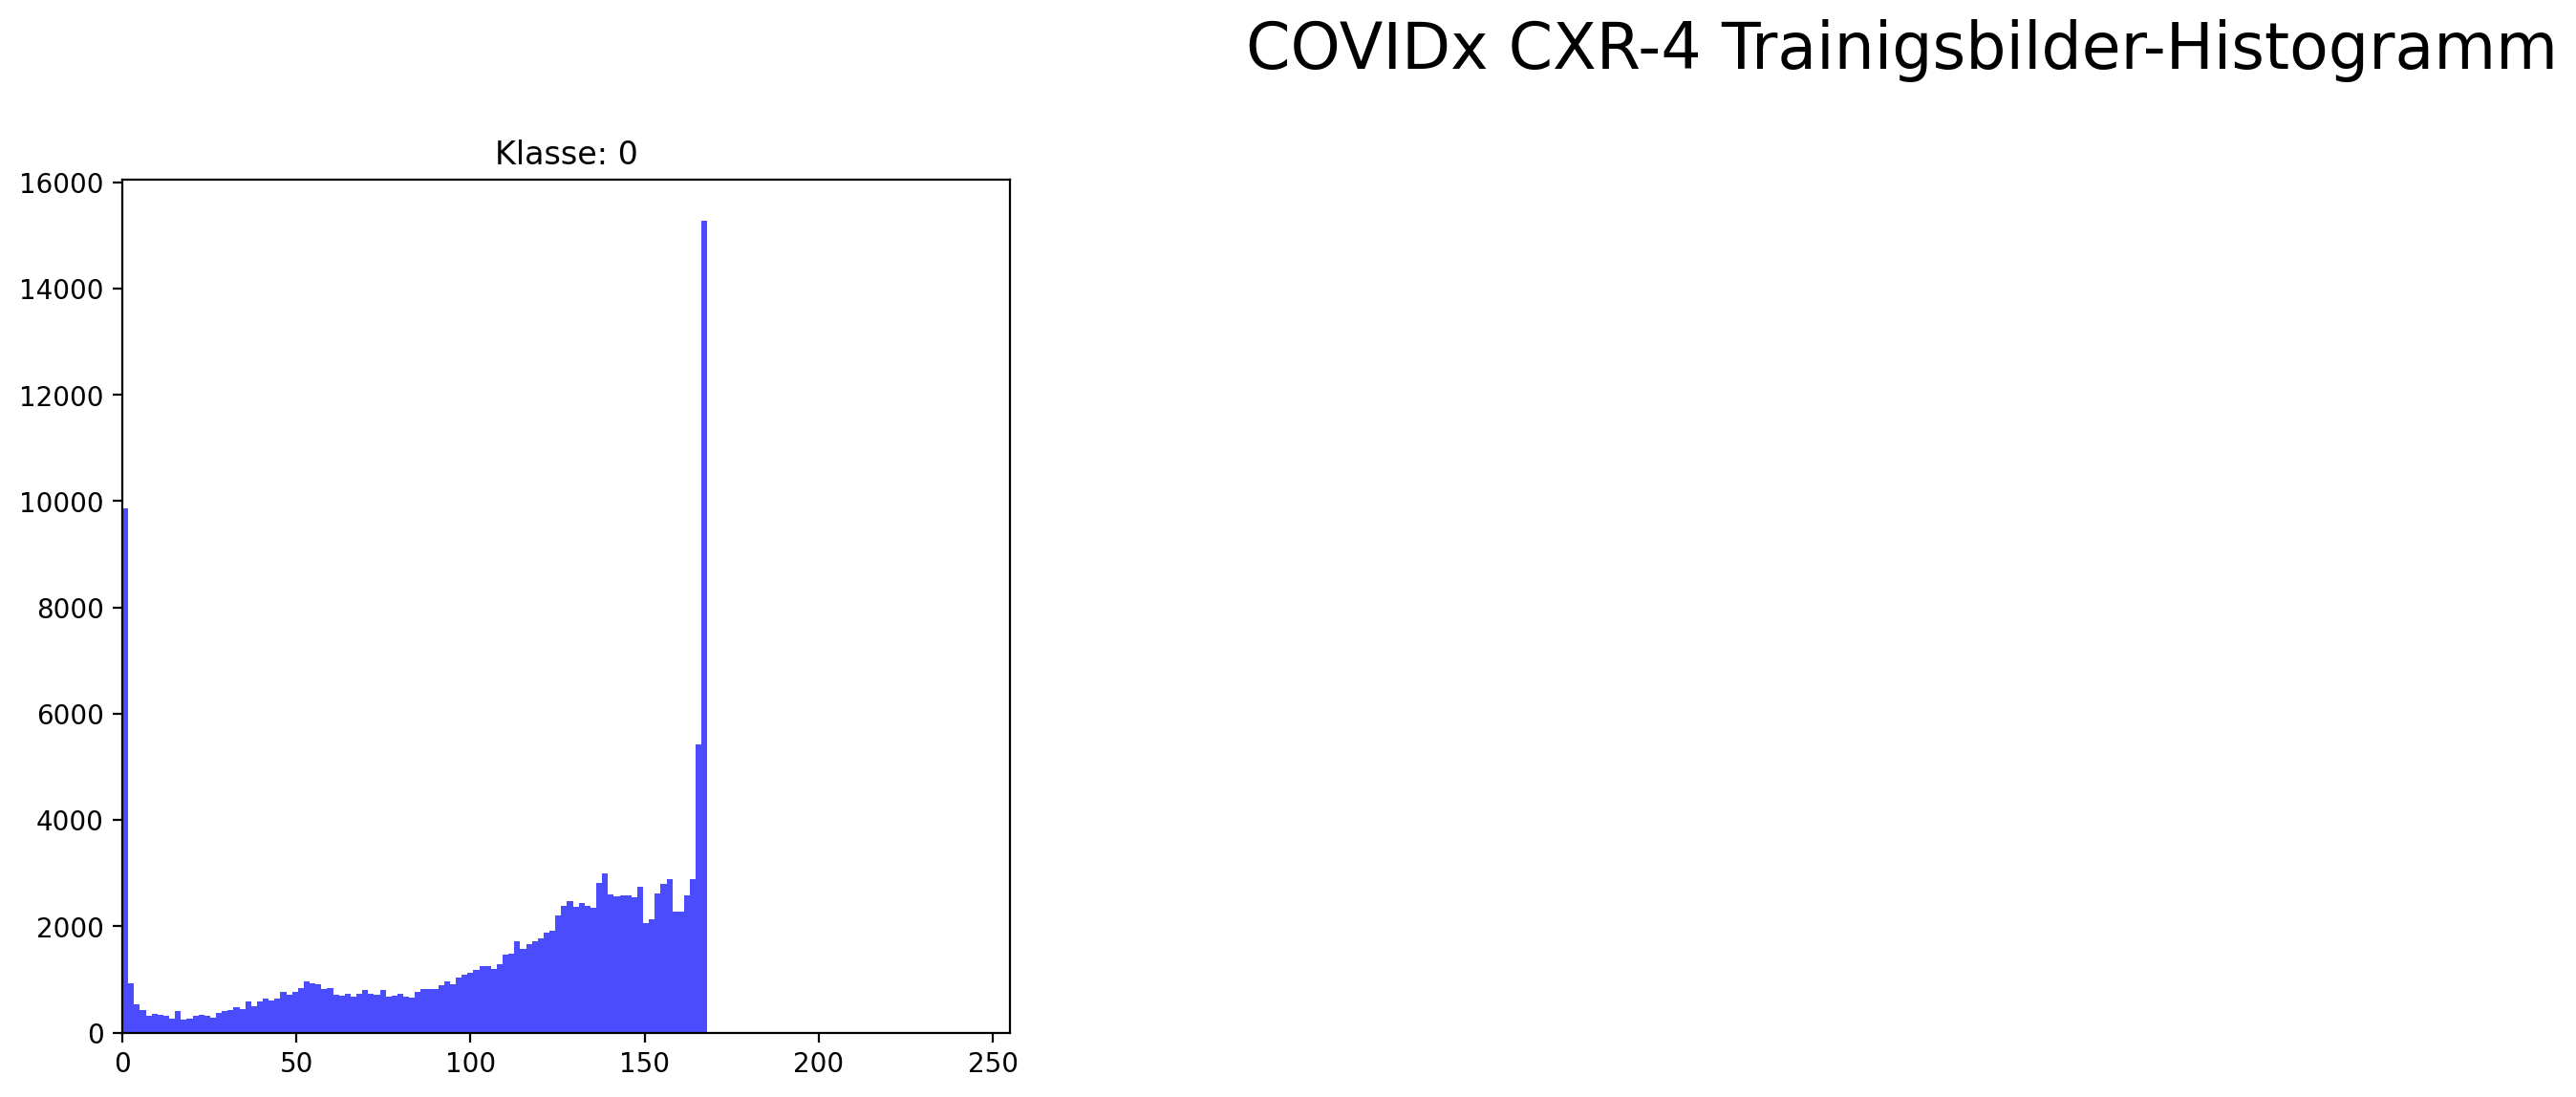

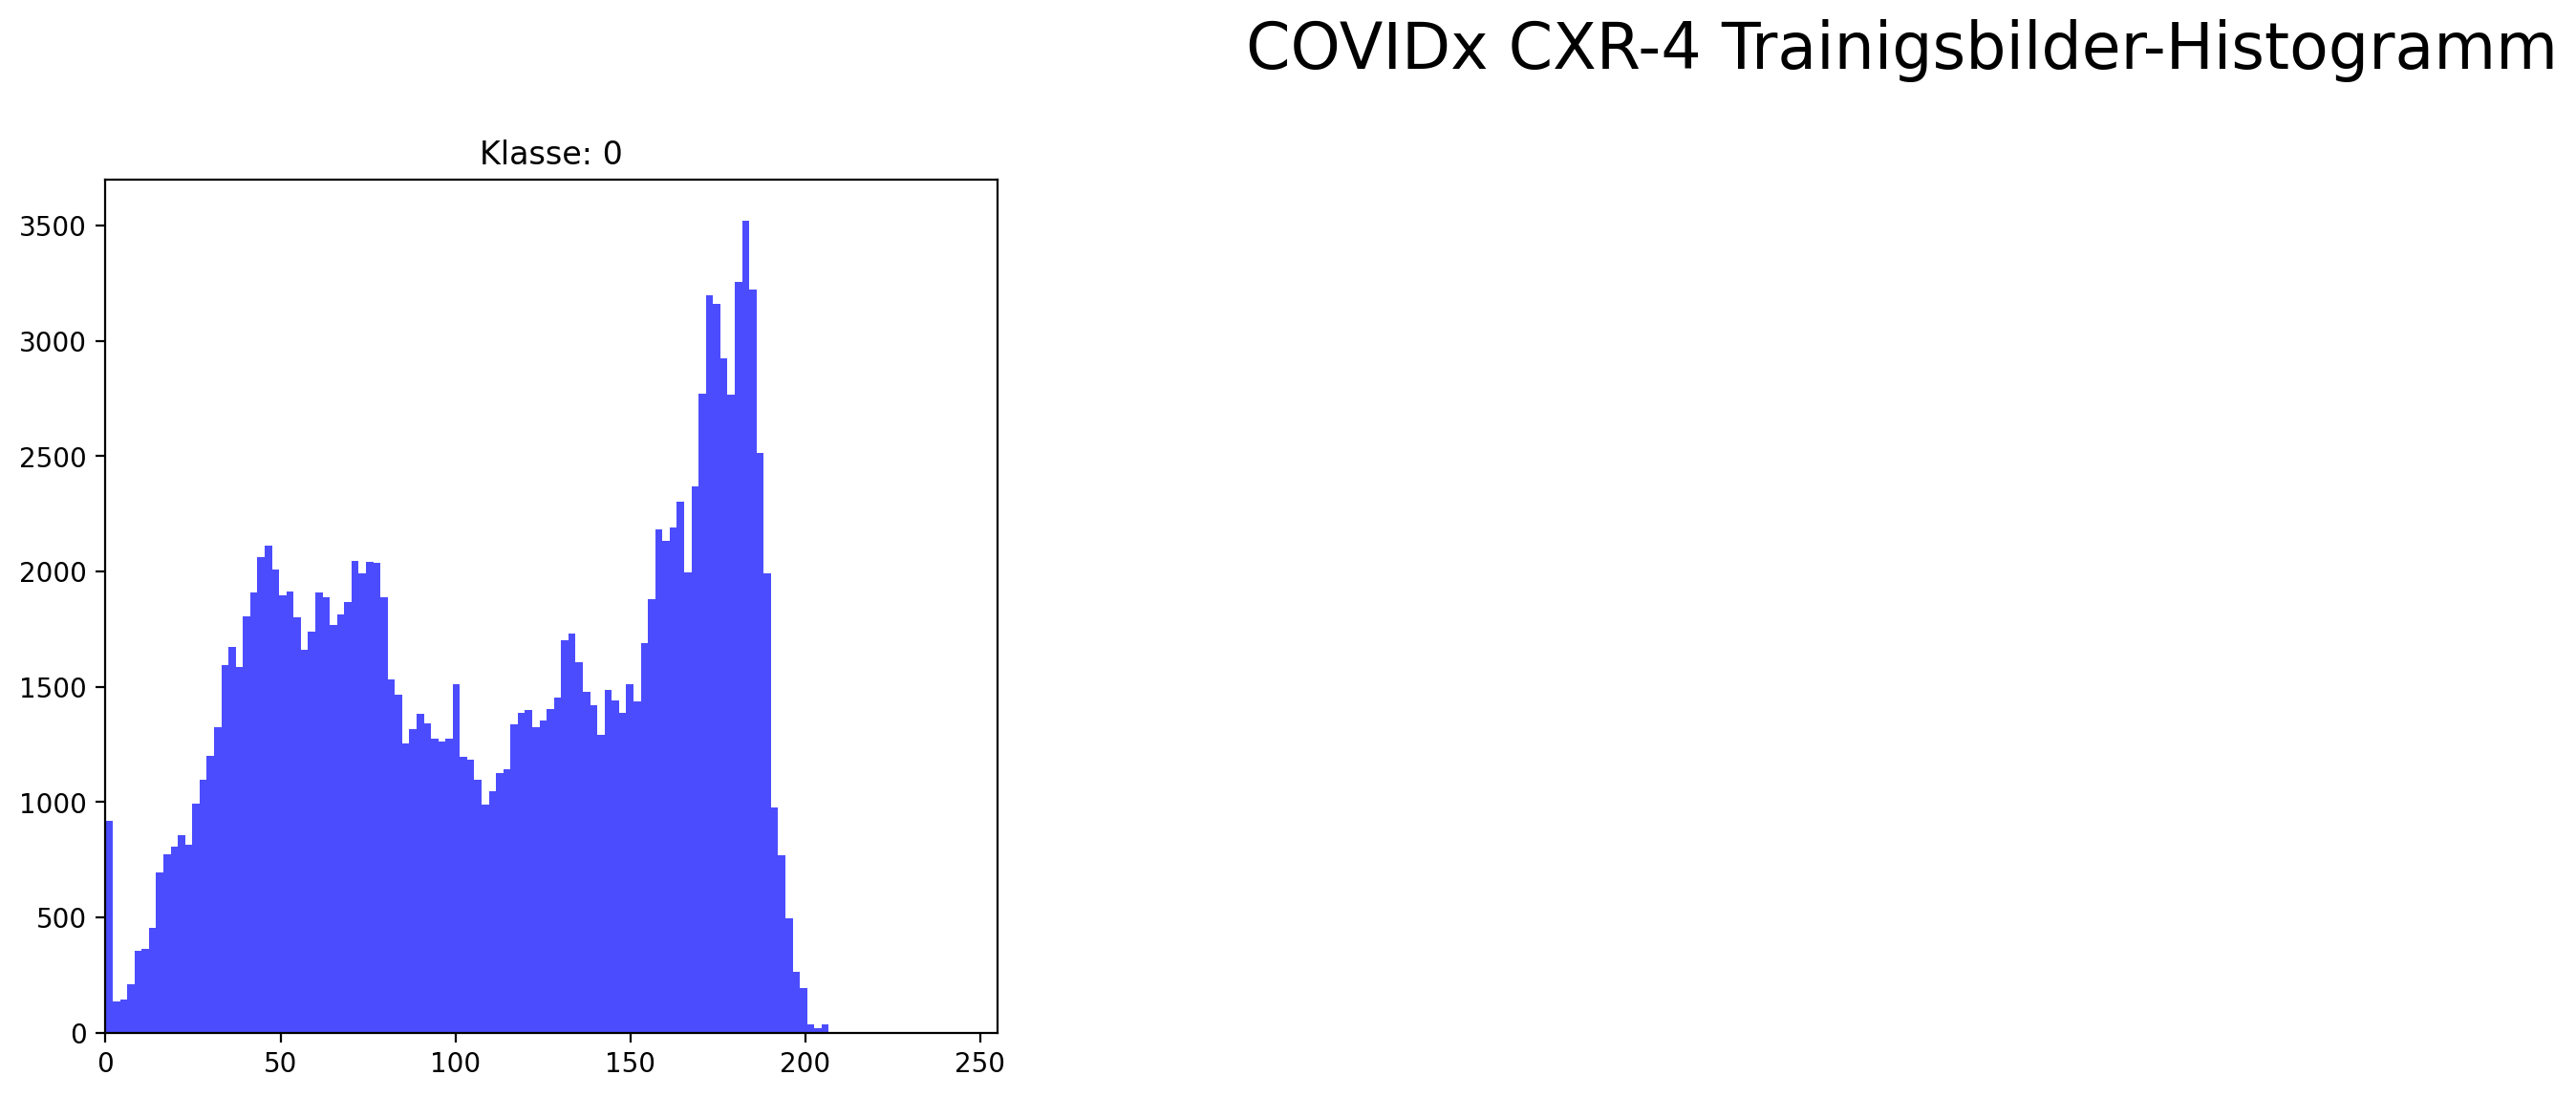

In [15]:
COVIDX_eda = ExplorativeDataAnalysis(COVIDXDataModule, 
                                     image_size=IMAGE_SIZE, 
                                     batchsize=BATCH_SIZE,
                                     dataloader_type="train",
                                     seed=18)

COVIDX_eda.show_batches(suptitle="COVIDx CXR-4 Trainigsbilder", 
                        batch_idx=[0, 75],
                        hist_mode=True)


In [173]:
example_image = COVIDX_eda.get_image_tensors(batch_idx=[60])[0][0][0]

In [174]:
example_image

tensor([[[148.3779, 142.3586, 133.8638,  ..., 125.8426, 130.1291, 129.7689],
         [203.4958, 195.9804, 185.4891,  ..., 195.9801, 195.0366, 145.3672],
         [201.9247, 194.6777, 185.7794,  ..., 196.5709, 195.8589, 175.6323],
         ...,
         [ 36.4307,  34.6395,  31.9966,  ...,   1.9762,  11.0166,  24.1438],
         [ 65.1397,  64.3681,  61.2185,  ...,   9.2947,  22.9769,  36.1944],
         [ 56.9140,  56.3353,  54.0336,  ...,   9.0264,  20.3665,  28.3388]],

        [[148.3779, 142.3586, 133.8638,  ..., 125.8426, 130.1291, 129.7689],
         [203.4958, 195.9804, 185.4891,  ..., 195.9801, 195.0366, 145.3672],
         [201.9247, 194.6777, 185.7794,  ..., 196.5709, 195.8589, 175.6323],
         ...,
         [ 36.4307,  34.6395,  31.9966,  ...,   1.9762,  11.0166,  24.1438],
         [ 65.1397,  64.3681,  61.2185,  ...,   9.2947,  22.9769,  36.1944],
         [ 56.9140,  56.3353,  54.0336,  ...,   9.0264,  20.3665,  28.3388]],

        [[148.3779, 142.3586, 133.8638,  ...

In [175]:
print(type(example_image))
print(type(perturb))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [176]:
adv_image = example_image + perturb

In [177]:
# turn adv_imag into int and clamp it to 0-255
adv_image = adv_image.int().clamp(0, 255)

adv_image

torchvision.utils.save_image(adv_image / 255, "adv_image.png")

# permute the dimensions to fit the image
adv_image = adv_image.permute(1, 2, 0)

adv_image


tensor([[[147, 147, 147],
         [141, 141, 141],
         [132, 132, 132],
         ...,
         [125, 125, 125],
         [130, 130, 130],
         [129, 129, 129]],

        [[202, 202, 202],
         [193, 193, 193],
         [182, 182, 182],
         ...,
         [196, 196, 196],
         [195, 195, 195],
         [145, 145, 145]],

        [[203, 203, 204],
         [196, 195, 196],
         [186, 186, 187],
         ...,
         [196, 196, 196],
         [195, 195, 195],
         [175, 175, 175]],

        ...,

        [[ 36,  36,  36],
         [ 34,  34,  34],
         [ 32,  32,  32],
         ...,
         [  1,   1,   1],
         [ 10,  10,  10],
         [ 24,  24,  24]],

        [[ 65,  65,  65],
         [ 64,  64,  64],
         [ 60,  61,  61],
         ...,
         [  9,   9,   9],
         [ 22,  22,  22],
         [ 36,  36,  36]],

        [[ 57,  57,  57],
         [ 55,  55,  55],
         [ 53,  53,  53],
         ...,
         [  8,   8,   8],
        

In [178]:
adv_image.shape

torch.Size([224, 224, 3])

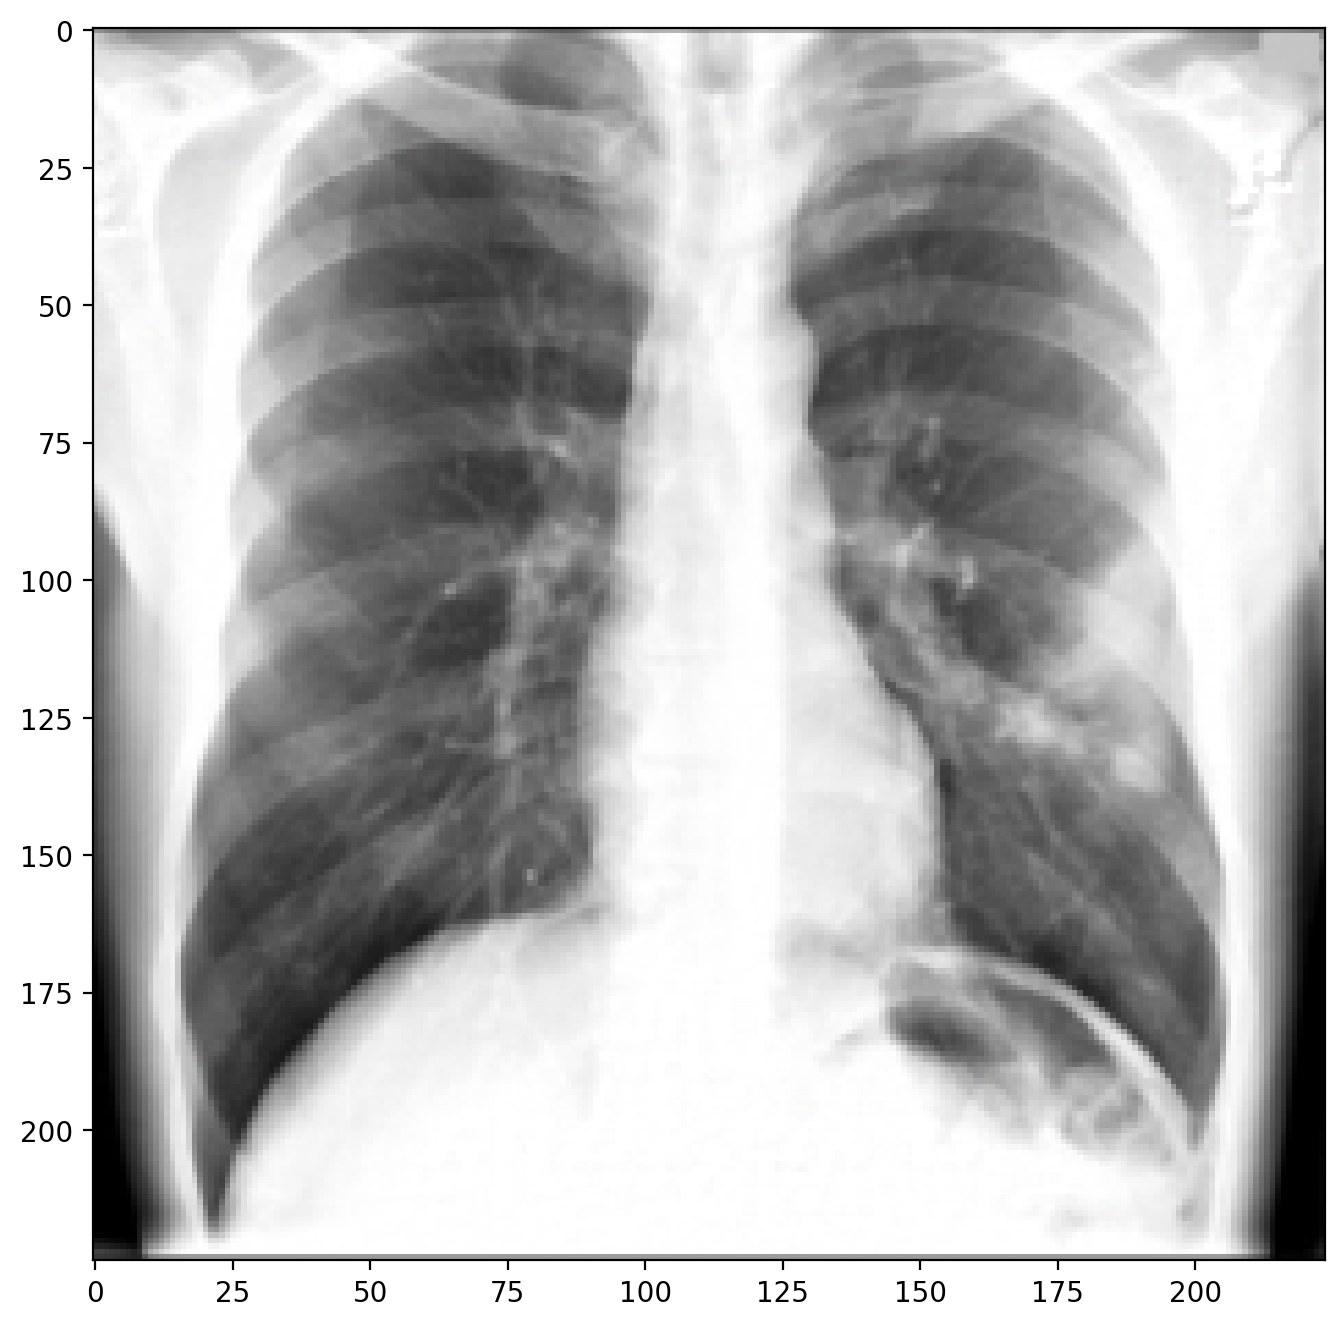

In [179]:
# visualize the adv_image
import matplotlib.pyplot as plt

plt.imshow(adv_image)
plt.show()
